In [67]:
import numpy as np
import pandas as pd
import cvxpy as cp
import scipy.stats
import copy
import time
import seaborn as sns
import matplotlib.style as style 
import matplotlib.pyplot as plt
import matplotlib
style.use('ggplot')# | style.use('seaborn-whitegrid')
#matplotlib.rcParams['font.family'] = "sans-serif"
sns.set_context('paper',font_scale=3) 
#ax.tick_params(axis='both', which='both', length=0)
#plt.figure(figsize=(8,6),dpi=120)
np.set_printoptions(suppress=True)

## simulate data

In [68]:
def SimulateQ(K,N):
    Xn = np.random.uniform(0,1+K,N)
    Q = np.zeros((N,K))
    for mean in range(1,K+1):
        Q[:,mean-1] = scipy.stats.norm(mean,1).pdf(Xn)
    Q = (Q.T/Q.sum(axis=1)).T
    Q = Q[np.lexsort((Q[:,2], Q[:,1],Q[:,0]))][::-1]
    return Q
def plotQ(Q,title):
    plt.figure(figsize=(12,6),dpi=50)
    N = Q.shape[0]
    plt.bar(range(N), Q[:,0], 1)
    for i in range(1,Q.shape[1]):
        plt.bar(range(N), Q[:,i], 1, bottom=Q[:,:(i)].sum(axis=1))
    plt.axis('off',which='both')
    plt.title(title)
    plt.show()
def SimulateG(Q,P):
    M = Q.dot(P)
    return np.random.binomial(2,M)

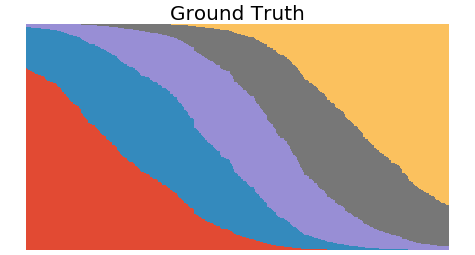

(500, 5) (5, 1000) (500, 1000)


In [297]:
M = 1000 # 10000
N = 500 # 1000, 10000
K = 5 # 5
P = np.random.uniform(0,1,M*K).reshape(K,M)
Q = SimulateQ(K,N)
G = SimulateG(Q,P)
plotQ(Q,'Ground Truth')
print(Q.shape, P.shape, G.shape)

## EM

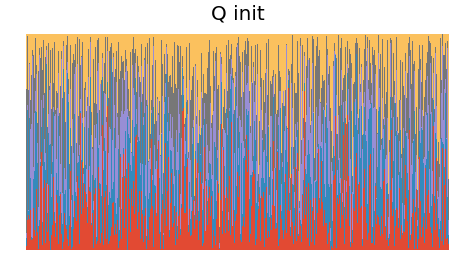

In [301]:
# initialization
Q_init = np.random.dirichlet(np.ones(K), N)#np.ones((N,K))/K
P_init = G.mean(axis=0)/2
P_init = np.repeat(P_init.reshape(-1,1),K,axis=1).T+np.random.randn(K,M)/20
P_init[P_init<=0.01] = 0.01
P_init[P_init>=0.99] = 0.99

# admixture 
Q_ad_init = copy.deepcopy(Q_init)
P_ad_init = copy.deepcopy(P_init)

A_init = np.zeros((N,M,K))
B_init = np.zeros((N,M,K))
plotQ(Q_init,'Q init')

In [243]:
def Likelihood(G,Q,P):
    return ((G*np.log(Q.dot(P))).sum()+((2-G)*np.log(Q.dot(1-P))).sum())/500000.0

L_init = Likelihood(G,Q_init,P_init)
L_best, L_init

(nan, -1.3252171275982247)

In [302]:
max_iter = 1000
em_start = time.time()
ep = np.inf
L_list = [L_init]
count = 0
while (ep > 1) and count<max_iter:
    for k in range(K):
        # E step
        A_init[:,:,k] = (Q_init[:,k].reshape(-1,1)).dot(P_init[k,:].reshape(1,-1))/Q_init.dot(P_init)
        B_init[:,:,k] = (Q_init[:,k].reshape(-1,1)).dot((1-P_init[k,:]).reshape(1,-1))/Q_init.dot(1-P_init)
        # M step
        P_init[k] = (G*A_init[:,:,k]).sum(axis=0)/((G*A_init[:,:,k]).sum(axis=0)+((2-G)*B_init[:,:,k]).sum(axis=0))
        Q_init[:,k] = ((G*A_init[:,:,k]).sum(axis=1)+((2-G)*B_init[:,:,k]).sum(axis=1))/(2*M)
    ep = (Likelihood(G,Q_init,P_init) - L_init)*500000
    L_init = Likelihood(G,Q_init,P_init)
    L_list.append(L_init)
    count += 1
    print("%.2f" % ep,end=',')
em_end = time.time()
print('time: %.2f' % (em_end-em_start))

33.68,949.38,660.55,453.89,319.23,237.35,193.37,177.29,182.99,207.27,249.06,308.92,388.56,490.48,617.41,771.71,954.45,1164.23,1395.83,1639.01,1877.66,2090.09,2250.84,2334.40,2320.99,2203.23,1991.40,1713.45,1408.15,1114.04,859.58,658.64,511.72,410.73,344.36,301.86,274.71,256.89,244.46,234.99,227.00,219.67,212.54,205.36,198.02,190.50,182.81,174.99,167.09,159.20,151.37,143.68,136.18,128.95,122.01,115.41,109.18,103.33,97.88,92.82,88.14,83.85,79.92,76.32,73.04,70.05,67.31,64.81,62.51,60.40,58.45,56.64,54.96,53.38,51.91,50.53,49.23,48.01,46.85,45.76,44.73,43.76,42.83,41.95,41.12,40.33,39.58,38.85,38.16,37.49,36.85,36.22,35.61,35.01,34.41,33.82,33.24,32.65,32.07,31.48,30.88,30.29,29.69,29.09,28.48,27.87,27.26,26.65,26.04,25.43,24.83,24.23,23.64,23.05,22.47,21.91,21.35,20.81,20.29,19.78,19.29,18.82,18.36,17.93,17.51,17.12,16.74,16.37,16.02,15.69,15.37,15.06,14.76,14.48,14.20,13.93,13.67,13.41,13.16,12.91,12.67,12.43,12.19,11.94,11.70,11.45,11.20,10.95,10.69,10.44,10.19,9.94,9.69,9.45,9.22,9.00

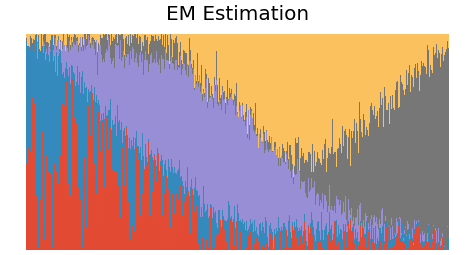

In [304]:
Q_init_sort = Q_init[:,Q_init[:(N//3),:].sum(axis=0).argsort()[::-1]]
sns.set_context('paper',font_scale=3) 
plotQ(Q_init_sort,'EM Estimation')

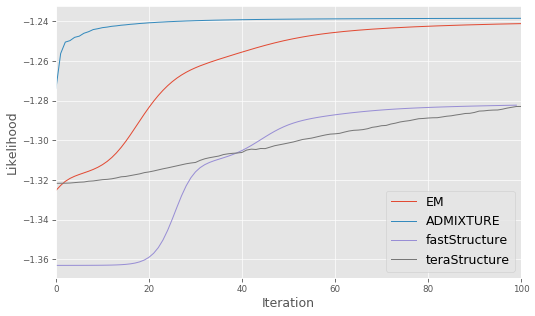

In [290]:
sns.set_context('paper',font_scale=1.2) 
np.set_printoptions(suppress=False)
plt.figure(figsize=(10,6),dpi=60)
plt.plot(range(len(L_list)),L_list,label='EM')
plt.plot(range(len(L_ad_list)),L_ad_list,label='ADMIXTURE')
plt.plot(range(len(E_list)),E_list,label='fastStructure')
plt.plot(range(len(E_list_tera)),E_list_tera,label='teraStructure')
plt.xlabel('Iteration',fontsize=15)
plt.ylabel('Likelihood',fontsize=15)
plt.xlim(0,100)
plt.legend(fontsize=15)
plt.show()

In [306]:
sqp_start = time.time()
ep = np.inf
L_ad_list = [L_init]
count = 0
while ((ep > 1) or (ep < 0)) and (count < max_iter):
    QP = Q_ad_init.dot(P_ad_init)
    QiP = Q_ad_init.dot(1-P_ad_init)
    QQ = np.zeros((N,K,K))
    for i_q in range(N):
        QQ[i_q] = Q_ad_init[i_q].reshape(-1,1).dot(Q_ad_init[i_q].reshape(1,-1))
    PP = np.zeros((M,K,K))
    iPiP = np.zeros((M,K,K))
    for i_p in range(M):
        PP[i_p] = P_ad_init[:,i_p].reshape(-1,1).dot(P_ad_init[:,i_p].reshape(1,-1))
        iPiP[i_p] = (1-P_ad_init[:,i_p]).reshape(-1,1).dot((1-P_ad_init[:,i_p]).reshape(1,-1))

    for i in range(N):
        # first differenltials
        dL_dQi = ((G[i,:].reshape(1,-1)*P_ad_init)/QP[i,:].reshape(1,-1)).sum(axis=1) + \
            (((2-G[i,:]).reshape(1,-1)*(1-P_ad_init))/QiP[i,:].reshape(1,-1)).sum(axis=1)
        # second differenltials
        d2L_dQi = -((G[i,:].reshape(-1,1,1)*PP)/(QP[i,:]**2).reshape(-1,1,1)).sum(axis=0) - \
                (((2-G[i,:]).reshape(-1,1,1)*iPiP)/(QiP[i,:]**2).reshape(-1,1,1)).sum(axis=0)
        delta_Qi = cp.Variable(K)
        prob_i = cp.Problem(cp.Maximize((1/2)*cp.quad_form(delta_Qi, d2L_dQi) + dL_dQi@delta_Qi),
                          [np.ones(K)@delta_Qi==0,delta_Qi>=-Q_ad_init[i], delta_Qi<=1-Q_ad_init[i]])
        try:
            prob_i.solve()
        except Exception:
            prob_i.solve(solver=cp.OSQP)
        Q_ad_init[i] = Q_ad_init[i]+np.array(delta_Qi.value).flatten()
        
    for j in range(M):
        # first differenltials
        dL_dPj = ((G[:,j].reshape(-1,1)*Q_ad_init)/QP[:,j].reshape(-1,1)).sum(axis=0) - \
            (((2-G[:,j]).reshape(-1,1)*Q_ad_init)/QiP[:,j].reshape(-1,1)).sum(axis=0)
        # second differenltials
        d2L_dPj = -((G[:,j].reshape(-1,1,1)*QQ)/(QP[:,j]**2).reshape(-1,1,1)).sum(axis=0) - \
            (((2-G[:,j]).reshape(-1,1,1)*QQ)/(QiP[:,j]**2).reshape(-1,1,1)).sum(axis=0)
        delta_Pj = cp.Variable(K)
        prob = cp.Problem(cp.Maximize((1/2)*cp.quad_form(delta_Pj, d2L_dPj) + dL_dPj@delta_Pj),
                          [delta_Pj>=-P_ad_init[:,j], delta_Pj<=1-P_ad_init[:,j]])
        try:
            prob.solve()
        except Exception:
            prob.solve(solver=cp.OSQP)
        P_ad_init[:,j] = P_ad_init[:,j]+np.array(delta_Pj.value).flatten()
    
    P_ad_init[P_ad_init<=0.00001] = 0.00001
    P_ad_init[P_ad_init>=0.99999] = 0.99999
    Q_ad_init[Q_ad_init<=0] = 0
    Q_ad_init[Q_ad_init>=1] = 1
    ep = (Likelihood(G,Q_ad_init,P_ad_init) - L_init)*500000
    L_init = Likelihood(G,Q_ad_init,P_ad_init)
    L_ad_list.append(L_init)
    count += 1
    print("%.2f" % ep,end=',')
    
sqp_end = time.time()
print(sqp_end-sqp_start)

-35979.99,-31932.73,46096.14,13130.48,3429.79,1392.38,970.89,852.94,598.97,386.90,151.84,115.78,56.04,85.45,44.57,71.31,39.79,60.12,36.56,52.58,34.07,46.40,32.30,41.26,30.08,36.62,27.35,31.61,24.34,27.11,21.35,23.30,18.75,20.03,16.60,17.25,14.87,15.14,13.38,13.31,11.96,11.71,10.78,10.40,9.79,9.26,8.84,8.31,7.95,7.54,7.24,6.92,6.62,6.37,6.11,5.97,5.75,5.56,5.32,5.20,4.97,4.85,4.61,4.48,4.18,4.03,3.76,3.63,3.35,3.20,2.96,2.85,2.64,2.54,2.37,2.30,2.13,2.08,1.96,1.93,1.83,1.82,1.73,1.73,1.66,1.66,1.59,1.59,1.50,1.49,1.43,1.43,1.37,1.37,1.31,1.29,1.23,1.20,1.14,1.11,1.05,1.02,0.95,1092.4791595935822


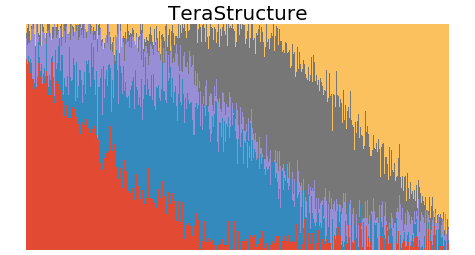

In [308]:
Q_ad_init_sort = Q_ad_init[:,Q_ad_init[:(N//2),:].sum(axis=0).argsort()[::-1]]
sns.set_context('paper',font_scale=3) 
plotQ(Q_ad_init_sort,'TeraStructure')

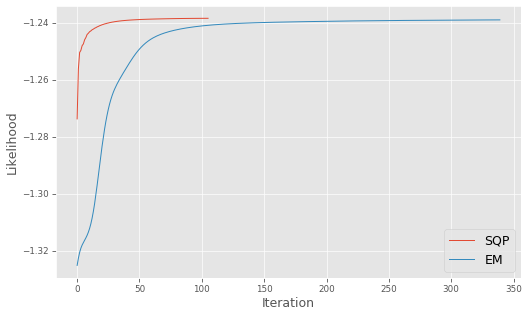

In [258]:
sns.set_context('paper',font_scale=1.2) 
np.set_printoptions(suppress=False)
plt.figure(figsize=(10,6),dpi=60)
plt.plot(range(len(L_ad_list)),L_ad_list,label='SQP')
plt.plot(range(len(L_list)),L_list,label='EM')
plt.xlabel('Iteration',fontsize=15)
plt.ylabel('Likelihood',fontsize=15)
plt.legend(fontsize=15)
plt.show()

In [245]:
L_ad_list

NameError: name 'L_ad_list' is not defined

## fastSTRUCTURE

In [125]:
import numpy as np
from scipy.special import digamma


class AdmixProp:

    def __init__(self,  N,  L,  K):

        """
        Sets initial parameter values for the variational distributions over
        admixture proportions. The prior over admixture proportions is set 
        to be a symmetric Dirichlet distribution with parameter 1/K.
        """

        self.N = N
        self.L = L
        self.K = K

        # Initializing hyperparameters
        self.alpha = 1./K*np.ones((1,K))

        # Initializing variational parameters for admixture proportions
        self.var = np.ones((N,K)) + 0.1*np.random.rand(N,K)
        self.xi = np.exp(digamma(self.var)-digamma(np.sum(self.var,axis=1,keepdims=True)))

    def update(self, G, pi):

        """
        Update parameters of variational distributions over 
        admixture proportions, given genotype data and estimates
        of parameters of variational distributions over allele
        frequencies.
        Arguments
            G : numpy array of genotypes
            pi : instance of `AlleleFreq`
        """
        
        self.var = np.zeros((self.N,self.K), dtype=np.float64)
        
        # Q_update
        # loop over samples
        for n in range(self.N):

            # loop over loci
            for l in range(self.L):

                normbeta = 0.0
                normgamma = 0.0
                genotype = G[n,l]

                # compute normalization
                for k in range(self.K):
                    normbeta += pi.zetabeta[l,k] * self.xi[n,k]
                    normgamma += pi.zetagamma[l,k] * self.xi[n,k]

                # loop over populations
                for k in range(self.K):
                    # compute new estimate of variational parameters
                    self.var[n,k] += (((2-genotype) * pi.zetagamma[l,k] / normgamma) + 
                                      (genotype * pi.zetabeta[l,k] / normbeta)) * self.xi[n,k]

        self.var = self.alpha + self.var
        self.xi = np.exp(digamma(self.var)-digamma(np.sum(self.var,axis=1,keepdims=True)))


In [126]:
import numpy as np

from scipy.special import digamma
import scipy.optimize as opt


class AlleleFreq:

    def __init__(self, N, L, K):

        """
        Sets initial parameter values for the variational distributions over
        allele frequencies. 
        """
        self.N = N
        self.L = L
        self.K = K

        self.beta = np.ones((self.L,self.K))
        self.gamma = np.ones((self.L,self.K))

        self.var_beta = np.ones((L,K)) + 0.1*np.random.rand(L,K)
        self.var_gamma = 10*np.ones((L,K)) + 0.1*np.random.rand(L,K)
        self.zetabeta = np.exp(digamma(self.var_beta) - digamma(self.var_beta+self.var_gamma))
        self.zetagamma = np.exp(digamma(self.var_gamma) - digamma(self.var_beta+self.var_gamma))


    def update(self, G, psi):

        """
        Update parameters of variational distributions over
        allele frequencies, given genotype data and estimates
        of parameters of variational distributions over admixture 
        proportions. This update method is called when the
        ``simple prior'' over allele frequencies is chosen.
        Arguments
            G : numpy array of genotypes
            psi : instance of `AdmixProp`
        """

        self.var_beta = np.zeros((self.L,self.K),dtype=np.float64)
        self.var_gamma = np.zeros((self.L,self.K),dtype=np.float64)
        
        # P update
        var_beta_tmp = np.zeros(self.K)
        var_gamma_tmp = np.zeros(self.K)

        # loop over loci
        for l in range(self.L):
            for k in range(self.K):

                var_beta_tmp[k] = 0.0
                var_gamma_tmp[k] = 0.0     

            # loop over samples
            for n in range(self.N):

                genotype = G[n,l]

                # compute xi*zeta_{beta,gamma}
                theta_beta_sum = 0.0
                theta_gamma_sum = 0.0

                for k in range(self.K):
                    theta_beta_sum += psi.xi[n,k] * self.zetabeta[l,k]
                    theta_gamma_sum += psi.xi[n,k] * self.zetagamma[l,k]

                # increment var_{beta,gamma}_tmp
                for k in range(self.K):
                    var_beta_tmp[k] += genotype * psi.xi[n,k] / theta_beta_sum
                    var_gamma_tmp[k] += (2-genotype) * psi.xi[n,k] / theta_gamma_sum

            # compute var_{beta,gamma}
            for k in range(self.K):
                self.var_beta[l,k] = self.beta[l,k] + self.zetabeta[l,k] * var_beta_tmp[k]
                self.var_gamma[l,k] = self.gamma[l,k] + self.zetagamma[l,k] * var_gamma_tmp[k]

        self.zetabeta = np.exp(digamma(self.var_beta) - digamma(self.var_beta+self.var_gamma))
        self.zetagamma = np.exp(digamma(self.var_gamma) - digamma(self.var_beta+self.var_gamma))


In [130]:
def marginal_likelihood(G, psi, pi):


    E1 = 0;
    # loop over loci
    for l in range(pi.L):
        
        # loop over samples 
        for n in range(pi.N):
            genotype = G[n,l]
            zasum = 0
            zbsum = 0

            # loop over populations
            if (genotype==0) :
                for k in range(pi.K):
                    zasum += pi.zetagamma[l,k]*psi.xi[n,k]
                zbsum = zasum

            elif (genotype==1) :
                for k in range(pi.K):
                    zasum += pi.zetagamma[l,k]*psi.xi[n,k]
                    zbsum += pi.zetabeta[l,k]*psi.xi[n,k]
                    
            elif (genotype==2) :
                for k in range(pi.K):
                    zasum += pi.zetabeta[l,k]*psi.xi[n,k]
                zbsum = zasum

            E1 += np.log(zasum) + np.log(zbsum)

    E2 = (np.sum(gammaln(psi.var) - gammaln(psi.alpha) - (psi.var-psi.alpha)*np.nan_to_num(np.log(psi.xi)),axis=1) \
        - gammaln(np.sum(psi.var,axis=1)) + gammaln(np.sum(psi.alpha,axis=1))).sum()

    E3 = (gammaln(pi.var_beta) - gammaln(pi.beta) - (pi.var_beta-pi.beta)*np.nan_to_num(np.log(pi.zetabeta)) \
        + gammaln(pi.var_gamma) - gammaln(pi.gamma) - (pi.var_gamma-pi.gamma)*np.nan_to_num(np.log(pi.zetagamma)) \
        - gammaln(pi.var_beta+pi.var_gamma) + gammaln(pi.beta+pi.gamma)).sum()

    Etotal = (E1 + E2 + E3)/float(psi.N*pi.L)

    return Etotal


In [146]:
import numpy as np
import time

from scipy.special import digamma, gammaln, polygamma


totaltime = time.time()
N = G.shape[0]
L = G.shape[1]
K = 5
itertime = time.time()

Estart = -np.inf
for restart in range(1):

    # simple initializing of variational parameters (cold start)
    psi = AdmixProp(N, L, K)
    pi = AlleleFreq(N, L, K)
    
    # compute marginal likelihood for this initialization
    psi.update(G, pi)
    pi.update(G, psi)
    E = marginal_likelihood(G, psi, pi)

    
itertime = time.time()-itertime
iter = 0
iter_max = 50
itertime = time.time()
reltol = np.inf
mintol = 2e-6
E_fast = []
while (np.abs(reltol)>mintol) and (iter < iter_max):

    psi.update(G, pi)
    pi.update(G, psi)

    # Compute marginal likelihood once every 10 iterations
    # if (iter+1)%5==0:

#     E_new = marginal_likelihood(G, psi, pi)
#     reltol = E_new-E
#     E = E_new
#     itertime = time.time()-itertime
#     iter += 1
#     E_list.append(E)
#     print('iter: %d    likelihood: %.6f   itertime: %.2f' %(iter, E, itertime))
#     print('reltol:',reltol)
#     itertime = time.time()
    
    P_fast = (pi.var_beta/(pi.var_beta+pi.var_gamma)).T
    Q_fast = psi.var/np.sum(psi.var,axis=1,keepdims=True)
    E_new = Likelihood(G,Q_tera,P_tera)
    reltol = E_new-E
    E = E_new
    itertime = time.time()-itertime
    iter += 1
    E_fast.append(E)
    print('iter: %d    likelihood: %.6f   itertime: %.2f' %(iter, E, itertime))
    print('reltol:',reltol)
    itertime = time.time()
    
# posterior mean of allele frequencies and admixture proportions
# P = pi.var_beta/(pi.var_beta+pi.var_gamma)
Q_fast = psi.var/np.sum(psi.var,axis=1,keepdims=True)

totaltime = time.time()-totaltime

iter: 1    likelihood: -1.363010   itertime: 34.91
reltol: 4.410365829210505e-06
iter: 2    likelihood: -1.363006   itertime: 34.32
reltol: 3.5707833734299754e-06
iter: 3    likelihood: -1.363002   itertime: 34.30
reltol: 3.745097314933332e-06
iter: 4    likelihood: -1.362998   itertime: 33.31
reltol: 4.049181074217145e-06
iter: 5    likelihood: -1.362994   itertime: 33.71
reltol: 4.536868323024024e-06
iter: 6    likelihood: -1.362989   itertime: 33.45
reltol: 5.295393797455361e-06
iter: 7    likelihood: -1.362982   itertime: 36.45
reltol: 6.462987408584198e-06
iter: 8    likelihood: -1.362974   itertime: 33.72
reltol: 8.256787320526371e-06
iter: 9    likelihood: -1.362963   itertime: 34.32
reltol: 1.101667243652571e-05
iter: 10    likelihood: -1.362948   itertime: 34.03
reltol: 1.5273754743416745e-05
iter: 11    likelihood: -1.362926   itertime: 34.03
reltol: 2.185699359680271e-05
iter: 12    likelihood: -1.362894   itertime: 34.31
reltol: 3.205843332421132e-05
iter: 13    likelihood:

In [157]:
while (np.abs(reltol)>mintol) and (iter < 100):

    psi.update(G, pi)
    pi.update(G, psi)

    # Compute marginal likelihood once every 10 iterations
    # if (iter+1)%5==0:

    E_new = marginal_likelihood(G, psi, pi)
    reltol = E_new-E
    E = E_new
    itertime = time.time()-itertime
    iter += 1
    E_list.append(E)
    print('iter: %d    likelihood: %.6f   itertime: %.2f' %(iter, E, itertime))
    print('reltol:',reltol)
    itertime = time.time()

iter: 51    likelihood: -1.292157   itertime: 626.49
reltol: 0.0009616473686151483
iter: 52    likelihood: -1.291324   itertime: 33.37
reltol: 0.0008332362438581153
iter: 53    likelihood: -1.290605   itertime: 33.30
reltol: 0.0007188575790220142
iter: 54    likelihood: -1.289983   itertime: 33.46
reltol: 0.0006218468386600673
iter: 55    likelihood: -1.289441   itertime: 33.76
reltol: 0.0005426404647643768
iter: 56    likelihood: -1.288961   itertime: 33.72
reltol: 0.0004797599684496223
iter: 57    likelihood: -1.288530   itertime: 34.05
reltol: 0.0004307242765133612
iter: 58    likelihood: -1.288138   itertime: 33.45
reltol: 0.0003927373234868803
iter: 59    likelihood: -1.287774   itertime: 33.31
reltol: 0.0003631252924796158
iter: 60    likelihood: -1.287435   itertime: 33.54
reltol: 0.0003395662270788691
iter: 61    likelihood: -1.287115   itertime: 33.72
reltol: 0.0003201755796480299
iter: 62    likelihood: -1.286811   itertime: 33.54
reltol: 0.0003035054481279609
iter: 63    lik

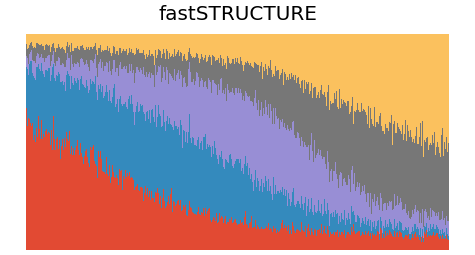

In [161]:
Q_fast_sort = Q_fast[:,Q_fast[:(N//2),:].sum(axis=0).argsort()[::-1]]
sns.set_context('paper',font_scale=3) 
plotQ(Q_fast_sort,'fastSTRUCTURE')

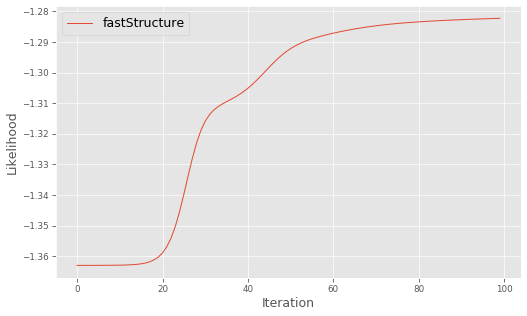

In [158]:
sns.set_context('paper',font_scale=1.2) 
np.set_printoptions(suppress=False)
plt.figure(figsize=(10,6),dpi=60)
plt.plot(range(len(E_list)),E_list,label='fastStructure')
plt.xlabel('Iteration',fontsize=15)
plt.ylabel('Likelihood',fontsize=15)
plt.legend(fontsize=15)
plt.show()

## TeraStructure

In [223]:
import numpy as np
from scipy.special import digamma


class AdmixProp_sample:

    def __init__(self,  N,  L,  K):

        """
        Sets initial parameter values for the variational distributions over
        admixture proportions. The prior over admixture proportions is set 
        to be a symmetric Dirichlet distribution with parameter 1/K.
        """

        self.N = N
        self.L = L
        self.K = K

        # Initializing hyperparameters
        self.alpha = 1./K*np.ones((1,K))

        # Initializing variational parameters for admixture proportions
        self.var = np.ones((N,K)) + 0.1*np.random.rand(N,K)
        self.xi = np.exp(digamma(self.var)-digamma(np.sum(self.var,axis=1,keepdims=True)))

    def update(self, G, pi, l_sample=None):

        """
        Update parameters of variational distributions over 
        admixture proportions, given genotype data and estimates
        of parameters of variational distributions over allele
        frequencies.
        Arguments
            G : numpy array of genotypes
            pi : instance of `AlleleFreq`
        """
        
        self.var = np.zeros((self.N,self.K), dtype=np.float64)
        
        # Q_update
        # loop over samples
        if l_sample == None:

            for n in range(self.N):

                # loop over loci
                for l in range(self.L):

                    normbeta = 0.0
                    normgamma = 0.0
                    genotype = G[n,l]

                    # compute normalization
                    for k in range(self.K):
                        normbeta += pi.zetabeta[l,k] * self.xi[n,k]
                        normgamma += pi.zetagamma[l,k] * self.xi[n,k]

                    # loop over populations
                    for k in range(self.K):
                        # compute new estimate of variational parameters
                        self.var[n,k] += (((2-genotype) * pi.zetagamma[l,k] / normgamma) + 
                                          (genotype * pi.zetabeta[l,k] / normbeta)) * self.xi[n,k]

            self.var = self.alpha + self.var
            self.xi = np.exp(digamma(self.var)-digamma(np.sum(self.var,axis=1,keepdims=True)))
            
        else:
            
            for n in range(self.N):

                # loop over loci
                for l in range(self.L):
                    
                    normbeta = 0.0
                    normgamma = 0.0
                    genotype = G[n,l_sample]

                    # compute normalization
                    for k in range(self.K):
                        normbeta += pi.zetabeta[l_sample,k] * self.xi[n,k]
                        normgamma += pi.zetagamma[l_sample,k] * self.xi[n,k]

                    # loop over populations
                    for k in range(self.K):
                        # compute new estimate of variational parameters
                        self.var[n,k] += (((2-genotype) * pi.zetagamma[l_sample,k] / normgamma) + 
                                          (genotype * pi.zetabeta[l_sample,k] / normbeta)) * self.xi[n,k]

            self.var = self.alpha + self.var
            self.xi = np.exp(digamma(self.var)-digamma(np.sum(self.var,axis=1,keepdims=True)))
            

In [275]:
import numpy as np
import pdb
from scipy.special import digamma
import scipy.optimize as opt


class AlleleFreq_sample:

    def __init__(self, N, L, K):

        """
        Sets initial parameter values for the variational distributions over
        allele frequencies. 
        """
        self.N = N
        self.L = L
        self.K = K

        self.beta = np.ones((self.L,self.K))
        self.gamma = np.ones((self.L,self.K))

        self.var_beta = np.ones((L,K)) + 0.1*np.random.rand(L,K)
        self.var_gamma = 10*np.ones((L,K)) + 0.1*np.random.rand(L,K)
        self.zetabeta = np.exp(digamma(self.var_beta) - digamma(self.var_beta+self.var_gamma))
        self.zetagamma = np.exp(digamma(self.var_gamma) - digamma(self.var_beta+self.var_gamma))


    def update(self, G, psi, l_sample=None):

        """
        Update parameters of variational distributions over
        allele frequencies, given genotype data and estimates
        of parameters of variational distributions over admixture 
        proportions. This update method is called when the
        ``simple prior'' over allele frequencies is chosen.
        Arguments
            G : numpy array of genotypes
            psi : instance of `AdmixProp`
        """

#         self.var_beta = np.zeros((self.L,self.K),dtype=np.float64)
#         self.var_gamma = np.zeros((self.L,self.K),dtype=np.float64)
        
        # P update
        var_beta_tmp = np.zeros(self.K)
        var_gamma_tmp = np.zeros(self.K)

        # update the sampled loci
        if l_sample != None:
            
            l = l_sample
            for k in range(self.K):

                var_beta_tmp[k] = 0.0
                var_gamma_tmp[k] = 0.0     

            # loop over samples
            for n in range(self.N):

                genotype = G[n,l]

                # compute xi*zeta_{beta,gamma}
                theta_beta_sum = 0.0
                theta_gamma_sum = 0.0

                for k in range(self.K):
                    theta_beta_sum += psi.xi[n,k] * self.zetabeta[l,k]
                    theta_gamma_sum += psi.xi[n,k] * self.zetagamma[l,k]

                # increment var_{beta,gamma}_tmp
                for k in range(self.K):
                    
                    var_beta_tmp[k] += genotype * psi.xi[n,k] / theta_beta_sum
                    var_gamma_tmp[k] += (2-genotype) * psi.xi[n,k] / theta_gamma_sum

            # compute var_{beta,gamma}
            for k in range(self.K):
                self.var_beta[l,k] = self.beta[l,k] + self.zetabeta[l,k] * var_beta_tmp[k]
                self.var_gamma[l,k] = self.gamma[l,k] + self.zetagamma[l,k] * var_gamma_tmp[k]
                
            self.zetabeta[l,:] = np.exp(digamma(self.var_beta[l,:]) - digamma(self.var_beta[l,:]+self.var_gamma[l,:]))
            self.zetagamma[l,:] = np.exp(digamma(self.var_gamma[l,:]) - digamma(self.var_beta[l,:]+self.var_gamma[l,:]))
            
        else:
            # loop over loci
            for l in range(self.L):
                for k in range(self.K):

                    var_beta_tmp[k] = 0.0
                    var_gamma_tmp[k] = 0.0     

                # loop over samples
                for n in range(self.N):

                    genotype = G[n,l]

                    # compute xi*zeta_{beta,gamma}
                    theta_beta_sum = 0.0
                    theta_gamma_sum = 0.0

                    for k in range(self.K):
                        theta_beta_sum += psi.xi[n,k] * self.zetabeta[l,k]
                        theta_gamma_sum += psi.xi[n,k] * self.zetagamma[l,k]

                    # increment var_{beta,gamma}_tmp
                    for k in range(self.K):
                        var_beta_tmp[k] += genotype * psi.xi[n,k] / theta_beta_sum
                        var_gamma_tmp[k] += (2-genotype) * psi.xi[n,k] / theta_gamma_sum

                # compute var_{beta,gamma}
                for k in range(self.K):
                    self.var_beta[l,k] = self.beta[l,k] + self.zetabeta[l,k] * var_beta_tmp[k]
                    self.var_gamma[l,k] = self.gamma[l,k] + self.zetagamma[l,k] * var_gamma_tmp[k]

            self.zetabeta = np.exp(digamma(self.var_beta) - digamma(self.var_beta+self.var_gamma))
            self.zetagamma = np.exp(digamma(self.var_gamma) - digamma(self.var_beta+self.var_gamma))
                


In [276]:
def marginal_likelihood_sample(G, psi, pi):


    E1 = 0;
    # loop over loci
    for l in range(pi.L):
        
        # loop over samples 
        for n in range(pi.N):
            genotype = G[n,l]
            zasum = 0
            zbsum = 0

            # loop over populations
            if (genotype==0) :
                for k in range(pi.K):
                    zasum += pi.zetagamma[l,k]*psi.xi[n,k]
                zbsum = zasum

            elif (genotype==1) :
                for k in range(pi.K):
                    zasum += pi.zetagamma[l,k]*psi.xi[n,k]
                    zbsum += pi.zetabeta[l,k]*psi.xi[n,k]
                    
            elif (genotype==2) :
                for k in range(pi.K):
                    zasum += pi.zetabeta[l,k]*psi.xi[n,k]
                zbsum = zasum

            E1 += np.log(zasum) + np.log(zbsum)
    pdb.set_trace()
    E2 = (np.sum(gammaln(psi.var) - gammaln(psi.alpha) - (psi.var-psi.alpha)*np.nan_to_num(np.log(psi.xi)),axis=1) \
        - gammaln(np.sum(psi.var,axis=1)) + gammaln(np.sum(psi.alpha,axis=1))).sum()

    E3 = (gammaln(pi.var_beta) - gammaln(pi.beta) - (pi.var_beta-pi.beta)*np.nan_to_num(np.log(pi.zetabeta)) \
        + gammaln(pi.var_gamma) - gammaln(pi.gamma) - (pi.var_gamma-pi.gamma)*np.nan_to_num(np.log(pi.zetagamma)) \
        - gammaln(pi.var_beta+pi.var_gamma) + gammaln(pi.beta+pi.gamma)).sum()

    Etotal = (E1 + E2 + E3)/float(psi.N*pi.L)

    return Etotal


In [280]:
import numpy as np
import time

from scipy.special import digamma, gammaln, polygamma


totaltime = time.time()
N = G.shape[0]
L = G.shape[1]
K = 5
itertime = time.time()

Estart = -np.inf
for restart in range(1):

    # simple initializing of variational parameters (cold start)
    psi = AdmixProp_sample(N, L, K)
    pi = AlleleFreq_sample(N, L, K)
    
    # compute marginal likelihood for this initialization
    pi.update(G, psi, None)
    psi.update(G, pi, None)
    E = marginal_likelihood(G, psi, pi)
    


itertime = time.time()-itertime
iter_a = 0
iter_b = 0
iter_max = 100
itertime = time.time()
reltol = np.inf
delta = np.inf
mintol_a = 1e-6
mintol_b = 2e-7
E_list_tera = []

zetabeta_old = pi.zetabeta.copy()
zetagamma_old = pi.zetagamma.copy()

while (iter_a < iter_max):
    
    for i in range(10):
        
        l_sample = np.random.randint(L)
        iter_b = 0
        delta = np.inf

        while (delta > mintol_b) and (iter_b < iter_max):
            pi.update(G, psi, l_sample)
            delta_beta = np.mean(pi.zetabeta[l_sample,:] - zetabeta_old[l_sample,:])
            delta_gamma = np.mean(pi.zetagamma[l_sample,:] - zetagamma_old[l_sample,:])
            delta = np.abs(delta_beta) + np.abs(delta_gamma)
            zetabeta_old = pi.zetabeta.copy()
            zetagamma_old = pi.zetagamma.copy()
            iter_b += 1
        
    psi.update(G, pi, l_sample)

    # E_new = marginal_likelihood_sample(G, psi, pi)

    # posterior mean of allele frequencies and admixture proportions
    P_tera = (pi.var_beta/(pi.var_beta+pi.var_gamma)).T
    Q_tera = psi.var/np.sum(psi.var,axis=1,keepdims=True)
    E_new = Likelihood(G,Q_tera,P_tera)
    reltol = E_new-E
    E = E_new
    itertime = time.time()-itertime
    iter_a += 1
    E_list_tera.append(E)
    print('iter: %d    likelihood: %.6f   itertime: %.2f' %(iter_a, E, itertime))
    print('reltol:',reltol)
    itertime = time.time()
    
    
totaltime = time.time()-totaltime

iter: 1    likelihood: -1.321648   itertime: 26.69
reltol: 0.04136526314929467
iter: 2    likelihood: -1.321620   itertime: 30.73
reltol: 2.797932444020823e-05
iter: 3    likelihood: -1.321574   itertime: 31.13
reltol: 4.64848362387027e-05
iter: 4    likelihood: -1.321495   itertime: 28.65
reltol: 7.854402186069365e-05
iter: 5    likelihood: -1.321288   itertime: 26.83
reltol: 0.0002068884245514102
iter: 6    likelihood: -1.321088   itertime: 29.21
reltol: 0.00020007935992305548
iter: 7    likelihood: -1.320975   itertime: 33.80
reltol: 0.00011340033552387219
iter: 8    likelihood: -1.320593   itertime: 35.23
reltol: 0.00038240326199323604
iter: 9    likelihood: -1.320443   itertime: 31.07
reltol: 0.0001498305785327947
iter: 10    likelihood: -1.320093   itertime: 31.38
reltol: 0.0003498245542263856
iter: 11    likelihood: -1.319797   itertime: 32.37
reltol: 0.0002957577144000467
iter: 12    likelihood: -1.319645   itertime: 33.95
reltol: 0.00015181723969748262
iter: 13    likelihood: 

In [285]:
while (iter_a < 200):
    
    for i in range(10):
        
        l_sample = np.random.randint(L)
        iter_b = 0
        delta = np.inf

        while (delta > mintol_b) and (iter_b < iter_max):
            pi.update(G, psi, l_sample)
            delta_beta = np.mean(pi.zetabeta[l_sample,:] - zetabeta_old[l_sample,:])
            delta_gamma = np.mean(pi.zetagamma[l_sample,:] - zetagamma_old[l_sample,:])
            delta = np.abs(delta_beta) + np.abs(delta_gamma)
            zetabeta_old = pi.zetabeta.copy()
            zetagamma_old = pi.zetagamma.copy()
            iter_b += 1
        
    psi.update(G, pi, l_sample)

    # E_new = marginal_likelihood_sample(G, psi, pi)

    # posterior mean of allele frequencies and admixture proportions
    P_tera = (pi.var_beta/(pi.var_beta+pi.var_gamma)).T
    Q_tera = psi.var/np.sum(psi.var,axis=1,keepdims=True)
    E_new = Likelihood(G,Q_tera,P_tera)
    reltol = E_new-E
    E = E_new
    itertime = time.time()-itertime
    iter_a += 1
    E_list_tera.append(E)
    print('iter: %d    likelihood: %.6f   itertime: %.2f' %(iter_a, E, itertime))
    print('reltol:',reltol)
    itertime = time.time()

iter: 101    likelihood: -1.282922   itertime: 230.84
reltol: 9.853462408671021e-06
iter: 102    likelihood: -1.282654   itertime: 21.10
reltol: 0.00026756624002000073
iter: 103    likelihood: -1.282401   itertime: 20.77
reltol: 0.0002533439490732814
iter: 104    likelihood: -1.281720   itertime: 20.57
reltol: 0.0006808538586424717
iter: 105    likelihood: -1.281438   itertime: 22.73
reltol: 0.00028155647350036617
iter: 106    likelihood: -1.281375   itertime: 20.80
reltol: 6.295303833825372e-05
iter: 107    likelihood: -1.281011   itertime: 21.16
reltol: 0.00036427318611220727
iter: 108    likelihood: -1.280657   itertime: 21.23
reltol: 0.0003541583566741835
iter: 109    likelihood: -1.280451   itertime: 18.78
reltol: 0.00020599792166375863
iter: 110    likelihood: -1.280289   itertime: 17.32
reltol: 0.00016231157794255324
iter: 111    likelihood: -1.279660   itertime: 17.46
reltol: 0.0006287395139006335
iter: 112    likelihood: -1.279189   itertime: 17.19
reltol: 0.000470622572824819

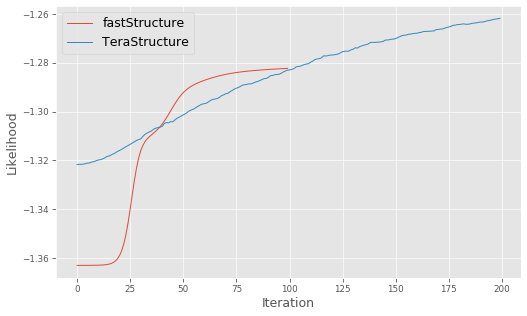

In [286]:
sns.set_context('paper',font_scale=1.2) 
np.set_printoptions(suppress=False)
plt.figure(figsize=(10,6),dpi=60)
plt.plot(range(len(E_list)),E_list,label='fastStructure')
plt.plot(range(len(E_list_tera)),E_list_tera,label='TeraStructure')
plt.xlabel('Iteration',fontsize=15)
plt.ylabel('Likelihood',fontsize=15)
plt.legend(fontsize=15)
plt.show()

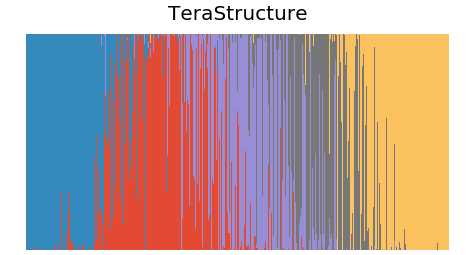

In [287]:
Q_tera_sort = Q_tera[:,Q_tera[:(N//2),:].sum(axis=0).argsort()[::-1]]
sns.set_context('paper',font_scale=3) 
plotQ(Q_tera_sort,'TeraStructure')